# Week 20 - Outro

မင်္ဂလာပါ၊ ဒီနေ့ နောက်ဆုံးပိတ် အိတ်နဲ့လွယ် ... Neural Network တွေကို စမ်းရေး၊ စမ်းသုံးကြည့်ကြမယ်။ 

ပထမဆုံး ရင်းနှီးပြီးသားဖြစ်တဲ့ myanmar-digits နဲ့ စပါမယ်။

In [ ]:
!git clone https://github.com/neolaw84/myanmar-digits.git

Cloning into 'myanmar-digits'...
remote: Enumerating objects: 97, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 97 (delta 0), reused 8 (delta 0), pack-reused 86
Unpacking objects: 100% (97/97), done.


In [1]:
%cd /home/edward/projects/myanmar-digits
#%cd myanmar-digits

/home/edward/projects/myanmar-digits


In [2]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
from datetime import datetime 

from sklearn import feature_selection as fs, model_selection as ms, metrics

import matplotlib.pyplot as plt

from myanmar_digits import load_data

/home/edward/anaconda3/envs/py37-dsup/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Preparation

### Import necessary modules

Neural Network ကို **pytorch** library ကို အသုံးပြုပြီး ရေးသားပါမယ်။ 

ဒီအတွက် `torch`, `torch.nn` နဲ့ `torchvision` တို့ထဲက လိုအပ်တာတွေကို import လုပ်ပါတယ်။

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from torchvision import datasets, transforms

# check device to use CUDA (GPU programming) if available
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

### Set parameters

Neural Network တခုမှာ အရေးပါတဲ့ parameter တွေကတော့

* learning_rate 
* batch_size နဲ့
* number_of_epoch တို့ပဲ ဖြစ်တယ်။

In [13]:
# parameters
RANDOM_SEED = 42
LEARNING_RATE = 0.002
BATCH_SIZE = 4
N_EPOCHS = 50

IMG_SIZE = 48
N_CLASSES = 10

## Load the data

Data ကို load လုပ်ပါမယ်။ 

In [5]:
X, y = load_data(as_frame=False, return_X_y=True, num_classes=N_CLASSES)
X.shape, y.shape

((4498, 2304), (4498,))

`torch` က `sklearn` လို မဟုတ်ပဲ 2D data structure (2d tensor) တင်မက 3D data structure (3d tensor) နဲ့ အဆင့်မြင့် kD data structure တွေကိုပါ ကိုင်တွယ်နိုင်တာမို့ရယ်၊ convolution လုပ်ချင်တာမို့ရယ် `X` ကို တလက်စတည်း 48x48 image တွေပါတဲ့ array ကြီးအဖြစ် `reshape` လုပ်လိုက်ပါတယ်။

In [6]:
X = (255 - X)/255.0
X = X.reshape( -1, 48, 48 )
y = y.astype(np.int8)

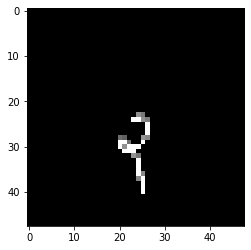

In [7]:
plt.imshow(X[1000], cmap="gray")
plt.show()

In [16]:
X = X[:, 8:-8, 8:-8]

### Train/Test splitting

data ကို load လုပ်ပြီးရင် မမေ့မလျော့ train/test split လုပ်ပါ။

In [17]:
tr_X, ts_X, tr_y, ts_y = ms.train_test_split(X, y, random_state=42)

### Create DataLoaders

နောက်တဆင့်မှာ torch ကသုံးတဲ့ DataLoader တွေအဖြစ်ကို အသွင်ပြောင်းရပါမယ်။

In [18]:
tr_tensor_x = torch.Tensor(tr_X) # transform to torch tensor
tr_tensor_y = torch.Tensor(tr_y).long()

ts_tensor_x = torch.Tensor(ts_X) # transform to torch tensor
ts_tensor_y = torch.Tensor(ts_y).long()

my_dataset = TensorDataset(tr_tensor_x, tr_tensor_y) # create your datset
my_dataloader = DataLoader(my_dataset, batch_size=BATCH_SIZE) # create your dataloader

ts_dataset = TensorDataset(ts_tensor_x, ts_tensor_y) # create your datset
ts_dataloader = DataLoader(ts_dataset, batch_size=BATCH_SIZE) # create your dataloader

## The Neural Network

### Defining the Training


Neural Network တခုကို train တဲ့အခါမှာ component ၃ ခုက အရေးကြီးပါတယ်။ 

1. Neural Network Definition
2. Optimizer
3. Loss function (`criterion`)

ပထမဆုံး Neural Network ရဲ့ definition ဟာ အရေးအကြီးဆုံးပါပဲ။ ဒီနေရာမှာ တချိန်က နာမည်ကြီးခဲ့တဲ့ LeNet5 ကို သုံးပါမယ်။ 

1. Layer 1 (C1): The first convolutional layer with 6 kernels of size 5×5 and the stride of 1. 
   
   Given the input size (48×48×1), the output of this layer is of size 44×44×6.

2. Layer 2 (S2): A subsampling/pooling layer with 6 kernels of size 2×2 and the stride of 2. The subsampling layer in the original architecture was a bit more complex than the traditionally used max/average pooling layers. I will quote the original paper: 
   
   > “ The four inputs to a unit in S2 are added, then multiplied by a trainable coefficient, and added to a trainable bias. The result is passed through a sigmoidal function.”. 
   
   As a result of non-overlapping receptive fields, the input to this layer is 1/4th in size (22×22×6).

3. Layer 3 (C3): The second convolutional layer with the same configuration as the first one, however, this time with 16 filters. The output of this layer is 18x18x16.

4. Layer 4 (S4): The second pooling layer. The logic is identical to the previous one, but this time the layer has 16 filters. 
   
   The output of this layer is of size 9×9×16.

5. Layer 5 (C5): The last convolutional layer with 20 5×5 kernels. 
   
   Given that the input to this layer is of size 9×9×16 and the kernels are of size 9×9, the output is 1×1×120. 

6. Layer 6 (F6): The first fully-connected layer, which takes the input of 120 units and returns 84 units. In the original paper, the authors used a custom activation function — a variant of the tanh activation function. 

7. Layer 7 (F7): The last dense layer, which outputs 10 units. In original paper, the authors used Euclidean Radial Basis Function neurons as activation functions for this layer.


In [19]:
#Defining the convolutional neural network
class LeNet5(nn.Module):

    def __init__(self, n_classes):
        super(LeNet5, self).__init__()
        
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1), # C1
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2), # S2
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1), #C3
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2), # S4
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1), #C5
            nn.Tanh(),
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84), #F6
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=n_classes), #F7
        )

    def forward(self, x):
        # print (x.size())
        x = x.unsqueeze(1)
        # print (x.size())
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs

torch.manual_seed(RANDOM_SEED)

model = LeNet5(N_CLASSES).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

### Actual training

Neural Network ကို define ပြီးရင် training စပါမယ်။ 

In [20]:
from torch.nn import functional as F

def get_accuracy(model, data_loader, device):
    '''
    Function for computing the accuracy of the predictions over the entire data_loader
    '''
    
    correct_pred = 0 
    n = 0
    
    with torch.no_grad():
        model.eval()
        for X, y_true in data_loader:

            X = X.to(device)
            y_true = y_true.to(device)

            _, y_prob = model(X)
            _, predicted_labels = torch.max(y_prob, 1)

            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()

    return correct_pred.float() / n

def train(train_loader, model, criterion, optimizer, device):
    '''
    Function for the training step of the training loop
    '''

    model.train()
    running_loss = 0
    
    for X, y_true in train_loader:

        optimizer.zero_grad()
        
        X = X.to(device)
        y_true = y_true.to(device)
    
        # Forward pass
        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 

        running_loss += loss.item() * X.size(0)

        # Backward pass
        loss.backward()
        optimizer.step()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

def validate(valid_loader, model, criterion, device):
    '''
    Function for the validation step of the training loop
    '''
   
    model.eval()
    running_loss = 0
    
    for X, y_true in valid_loader:
    
        X = X.to(device)
        y_true = y_true.to(device)

        # Forward pass and record loss
        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)
        
    return model, epoch_loss

def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1):
    '''
    Function defining the entire training loop
    '''
    
    # set objects for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []
 
    # Train model
    for epoch in range(0, epochs):

        # training
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)

        # validation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):
            
            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)
                
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')
    
    return model, optimizer, (train_losses, valid_losses)

In [22]:
model, optimizer, _ = training_loop(
    model=model, 
    criterion=criterion, 
    optimizer=optimizer, 
    train_loader=my_dataloader, 
    valid_loader=ts_dataloader, 
    epochs=N_EPOCHS, 
    device=DEVICE,
    print_every=1
)

20:38:10 --- Epoch: 0	Train loss: 0.5919	Valid loss: 0.6401	Train accuracy: 84.85	Valid accuracy: 78.84
20:38:15 --- Epoch: 1	Train loss: 0.4383	Valid loss: 0.5546	Train accuracy: 87.67	Valid accuracy: 80.36
20:38:20 --- Epoch: 2	Train loss: 0.3723	Valid loss: 0.5735	Train accuracy: 88.32	Valid accuracy: 81.51
20:38:25 --- Epoch: 3	Train loss: 0.2981	Valid loss: 0.5561	Train accuracy: 89.80	Valid accuracy: 82.67
20:38:31 --- Epoch: 4	Train loss: 0.2575	Valid loss: 0.5394	Train accuracy: 91.25	Valid accuracy: 82.58
20:38:37 --- Epoch: 5	Train loss: 0.2583	Valid loss: 0.4542	Train accuracy: 93.66	Valid accuracy: 87.02
20:38:42 --- Epoch: 6	Train loss: 0.2208	Valid loss: 0.5113	Train accuracy: 93.27	Valid accuracy: 86.13
20:38:48 --- Epoch: 7	Train loss: 0.1866	Valid loss: 0.5879	Train accuracy: 92.20	Valid accuracy: 83.20
20:38:53 --- Epoch: 8	Train loss: 0.1630	Valid loss: 0.5242	Train accuracy: 94.78	Valid accuracy: 87.38
20:38:58 --- Epoch: 9	Train loss: 0.1790	Valid loss: 0.5185	Trai

## Finally, evaluate

Evaluate လုပ်ဖို့ test set ကို model ထဲ ထည့်ရမယ်။

In [40]:
model.eval()

ts_tensor_x_ = ts_tensor_x.to(DEVICE)

y_hat, probs = model(ts_tensor_x_) 
y_hat = y_hat.argmax(dim=1)
pred_y = y_hat.cpu().detach().numpy()

print (metrics.classification_report(ts_y, pred_y))

              precision    recall  f1-score   support

           0       0.82      0.70      0.76        44
           1       0.75      0.77      0.76        47
           2       0.94      0.93      0.93       108
           3       0.92      0.95      0.93       149
           4       0.98      0.92      0.95       154
           5       0.82      0.83      0.83       188
           6       0.82      0.86      0.84       125
           7       0.83      0.82      0.83       123
           8       0.79      0.89      0.84       100
           9       0.87      0.83      0.85        87

    accuracy                           0.87      1125
   macro avg       0.86      0.85      0.85      1125
weighted avg       0.87      0.87      0.87      1125



In [41]:
print (metrics.confusion_matrix(ts_y, pred_y))

[[ 31   2   0   0   0   0   2   0   9   0]
 [  4  36   3   0   0   2   0   0   2   0]
 [  0   2 100   2   0   2   0   1   0   1]
 [  0   2   2 141   0   0   0   1   0   3]
 [  0   2   0   3 141   5   0   3   0   0]
 [  0   0   1   2   0 156  13  10   5   1]
 [  0   2   0   1   0   7 107   3   2   3]
 [  0   1   0   0   3  15   1 101   1   1]
 [  3   0   0   1   0   1   4   0  89   2]
 [  0   1   0   3   0   2   3   2   4  72]]
